# Render PGN to augmented images

# Imports

In [1]:
import chess
import chess.pgn
import chess.svg
import cairosvg
import requests
from pprint import pprint
import io
import os
import json
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
import random
from sklearn.model_selection import train_test_split

 # Get games from user

In [4]:
players_usernames = ["Hikaru", "magnuscarlsen", "firouzja2003", "gukeshdommaraju", "lachesisq", "fabianocaruana", "hansontwitch"]

username = "magnuscarlsen"
year = "2025"
month = "01"

headers = {
    "Content-Type": "application/json",
    "User-Agent": "chess-api-test/0.1 (username: AlexCQJ; contact: alex.c.quiroga.jaldin@gmail.com)"
}

url = f"https://api.chess.com/pub/player/{username}/games/{year}/{month}"
response = requests.get(url, headers=headers)
if response.status_code == 200:
    player_games_archive = response.json()
    print("Keys: ", player_games_archive.keys())
    print("games keys: ", player_games_archive["games"][0].keys())
    print("Number of games: ", len(player_games_archive["games"]))
    selected_games = player_games_archive["games"]
    pprint(selected_games[0])
else:
    print(f"Error fetching games archive for {username} in {year}-{month}: {response.status_code}")

Keys:  dict_keys(['games'])
games keys:  dict_keys(['url', 'pgn', 'time_control', 'end_time', 'rated', 'accuracies', 'tcn', 'uuid', 'initial_setup', 'fen', 'time_class', 'rules', 'white', 'black', 'eco'])
Number of games:  364
{'accuracies': {'black': 99.29, 'white': 99.26},
 'black': {'@id': 'https://api.chess.com/pub/player/magnuscarlsen',
           'rating': 3301,
           'result': 'repetition',
           'username': 'MagnusCarlsen',
           'uuid': 'a2761738-b155-11df-8018-000000000000'},
 'eco': 'https://www.chess.com/openings/Queens-Gambit-Declined-Pseudo-Tarrasch-Defense-4.g3',
 'end_time': 1735927615,
 'fen': '8/5Q1k/6p1/p4p1p/P3p2P/2q1P1P1/4KP2/8 b - -',
 'initial_setup': 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1',
 'pgn': '[Event "Live Chess"]\n'
        '[Site "Chess.com"]\n'
        '[Date "2025.01.03"]\n'
        '[Round "-"]\n'
        '[White "NikoTheodorou"]\n'
        '[Black "MagnusCarlsen"]\n'
        '[Result "1/2-1/2"]\n'
        '[CurrentPo

# Parse game's PGN

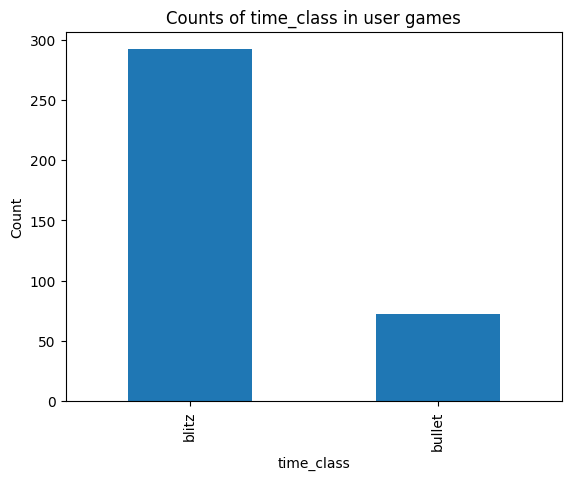

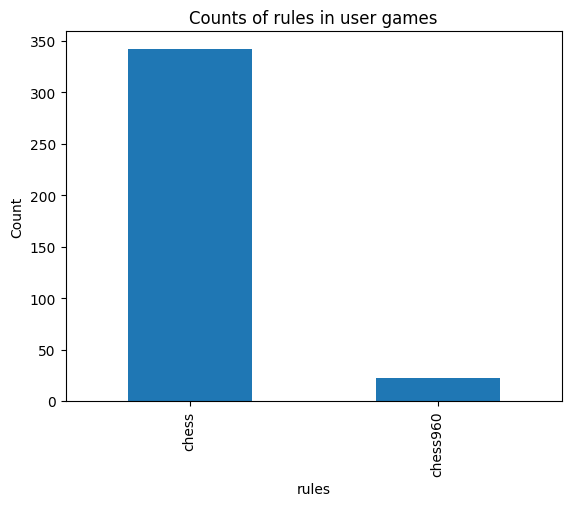

In [7]:
games_info = {
    "time_class": [],
    "rules": [],
}

for game in selected_games:
    games_info["time_class"].append(game["time_class"])
    games_info["rules"].append(game["rules"])
    
df_games_info = pd.DataFrame(games_info)

for col in df_games_info.columns:
    counts = df_games_info[col].value_counts()
    counts.plot(kind='bar', title=f"Counts of {col} in user games")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()
    

In [8]:
chess_games = [game for game in selected_games if game["time_class"] == "blitz" and game["rules"] == "chess"]

print(f"Number of chess games: {len(chess_games)}")

Number of chess games: 270


In [ ]:
def get_game_info(game_number):
    game_json = selected_games[game_number]
    game_pgn = game_json["pgn"]
    player_white = game_json["white"]
    player_black = game_json["black"]
    
    return {
        "pgn": game_pgn,
        "white": player_white,
        "black": player_black
    }
    
def board2arr(board):
    pieces_map = board.piece_map()
    pieces_map = {k: v.symbol() for k, v in pieces_map.items()}

    PIECES_NUMBERS = [
        56, 57, 58, 59, 60, 61, 62, 63,
        48, 49, 50, 51, 52, 53, 54, 55,
        40, 41, 42, 43, 44, 45, 46, 47,
        32, 33, 34, 35, 36, 37, 38, 39,
        24, 25, 26, 27, 28, 29, 30, 31,
        16, 17, 18, 19, 20, 21, 22, 23,
        8, 9, 10, 11, 12, 13, 14, 15,
        0, 1, 2, 3, 4, 5, 6, 7
    ]

    pieces_squares = list(map(lambda x: pieces_map.get(x, "0"), PIECES_NUMBERS))

    pieces_arr = np.array(pieces_squares).reshape(8, 8)

    return pieces_arr

def render_board(board, colors):
    svg_data = chess.svg.board(
        board=board,
        size=400,
        # colors={
        #     "square light": "#f0d9b5",
        #     "square dark": "#b58863"
        # }
        colors=colors,
        orientation=chess.WHITE, # chess.WHITE, chess.BLACK
        coordinates=False,
        #style = style_css
        #pieces=piece_images
    ) # SVG XML

    # Convert SVG to PNG bytes
    # SVG XML > XML string > SVG bytes > PNG bytes
    png_bytes = cairosvg.svg2png(bytestring=svg_data.encode('utf-8'))
    
    # Create a BytesIO object to work with the PNG data
    png_io = io.BytesIO(png_bytes)
    
    # Read the PNG into a numpy array using plt.imread
    img_array = plt.imread(png_io)
    
    return img_array

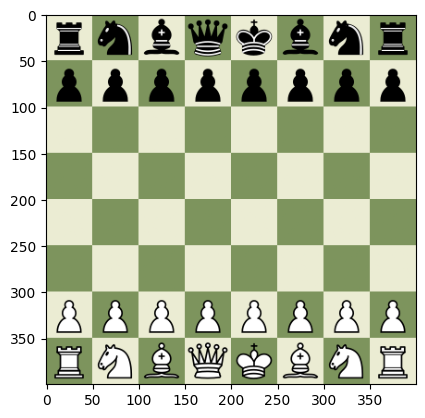

In [49]:
# Chess.com colors
colors = {
    "square light": "#EBECD3",
    "square dark": "#7D945D"
}


# Create a chess board instance at the starting position
board = chess.Board()

# Render the board with your custom PNG pieces
img_board = render_board(board, colors=colors)

# Display the resulting board image using matplotlib
plt.imshow(img_board)
#plt.axis('off') # Hide the axes
plt.show()


- https://github.com/anandjoshi91/chessboard-image/blob/main/chessboard_image/generator.py

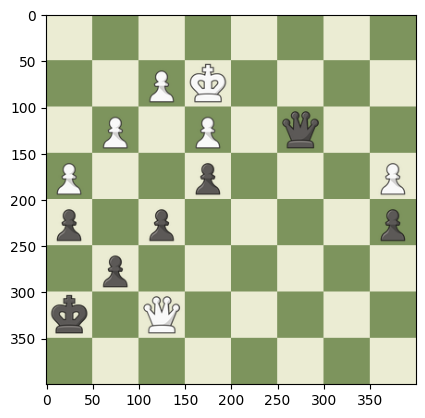

In [57]:
import chess
import pathlib
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# --- Create a directory for piece images ---
# This part is for making the example runnable.
# You should have your own 'piece_images' folder with your PNGs.
current_dir = pathlib.Path()
pieces_dir = current_dir / "piece_images"
pieces_dir.mkdir(exist_ok=True)

def create_dummy_piece_image(filepath, color):
    """Creates a simple colored square as a placeholder piece image."""
    img = Image.new('RGBA', (60, 60), (0, 0, 0, 0)) # Transparent background
    draw = ImageDraw.Draw(img)
    draw.rectangle([5, 5, 55, 55], fill=color)
    img.save(filepath, 'PNG')

# --- IMPORTANT ---
# This dictionary should point to your actual PNG files.
# The code below creates placeholder images if they don't exist.
piece_images = {
    'K': pieces_dir / "wK.png", 'Q': pieces_dir / "wQ.png", 'R': pieces_dir / "wR.png",
    'B': pieces_dir / "wB.png", 'N': pieces_dir / "wN.png", 'P': pieces_dir / "wP.png",
    'k': pieces_dir / "bK.png", 'q': pieces_dir / "bQ.png", 'r': pieces_dir / "bR.png",
    'b': pieces_dir / "bB.png", 'n': pieces_dir / "bN.png", 'p': pieces_dir / "bP.png",
}

# --- Create dummy images for demonstration if they don't exist ---
if not piece_images['K'].exists():
    print("Creating dummy placeholder images...")
    # White pieces (light gray)
    for piece in ['K', 'Q', 'R', 'B', 'N', 'P']:
        create_dummy_piece_image(piece_images[piece], 'lightgray')
    # Black pieces (dark gray)
    for piece in ['k', 'q', 'r', 'b', 'n', 'p']:
        create_dummy_piece_image(piece_images[piece], 'darkgray')


def get_board_representation(board):
    """Converts a chess.Board object to a 2D list representation."""
    board_str = str(board).replace(' ', '')
    rows = board_str.split('\n')
    board_repr = [list(row) for row in rows]
    return board_repr

def draw_board(board_repr, piece_paths, board_colors, player_pov="white", size=400):
    """
    Draws a chessboard with pieces loaded from image files.

    Args:
        board_repr (list): 2D list representing the board state.
        piece_paths (dict): Dictionary mapping piece symbols to image file paths.
        board_colors (tuple): A tuple of (light_square_color, dark_square_color).
        player_pov (str): The perspective of the board ('white' or 'black').
        size (int): The size of the board image in pixels.
    """
    if player_pov == "black":
        board_repr = board_repr[::-1]
        board_repr = [row[::-1] for row in board_repr]
    
    img = Image.new('RGB', (size, size), 'white')
    draw = ImageDraw.Draw(img)
    
    square_size = size // 8
    light_color, dark_color = board_colors
    
    # Draw squares
    for row in range(8):
        for col in range(8):
            x1, y1 = col * square_size, row * square_size
            x2, y2 = x1 + square_size, y1 + square_size
            color = light_color if (row + col) % 2 == 0 else dark_color
            draw.rectangle([x1, y1, x2, y2], fill=color)
            
    # Place pieces
    for row in range(8):
        for col in range(8):
            piece_symbol = board_repr[row][col]
            if piece_symbol != '.' and piece_symbol in piece_paths:
                # Open the piece image from the file path
                piece_img = Image.open(piece_paths[piece_symbol])
                
                # Resize piece to fit the square
                piece_img = piece_img.resize((square_size, square_size), Image.Resampling.LANCZOS)
                
                x, y = col * square_size, row * square_size
                
                # Paste the piece, using its alpha channel for transparency
                if piece_img.mode == 'RGBA':
                    img.paste(piece_img, (x, y), piece_img)
                else:
                    img.paste(piece_img, (x, y))

    return img

# --- Main execution ---

# 1. Define board colors
board_theme_colors = ("#EBECD3", "#7D945D")

# 2. Create a chess board instance (e.g., starting position)
#board = chess.Board()
pgn = io.StringIO(chess_games[0]["pgn"])
chess_game = chess.pgn.read_game(pgn)
board = chess_game.end().board()

# 3. Get the 2D list representation of the board
board_array = get_board_representation(board)

# 4. Render the board with your custom PNG pieces
img_board = draw_board(board_array, piece_images, board_theme_colors, player_pov="black")

# 5. Display the resulting board image
plt.imshow(img_board)
#plt.axis('off') # Hide the axes
plt.show()